# All imports

This file contains code for MobileNetV2, NASNetMobile, ResNet50

In [1]:
import cv2
import os
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Drive Set up

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten',
    'mid': '/content/drive/MyDrive/data/mid',
    'fresh': '/content/drive/MyDrive/data/fresh'
}

In [4]:
output_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten_frames',
    'mid': '/content/drive/MyDrive/data/mid_frames',
    'fresh': '/content/drive/MyDrive/data/fresh_frames'
}

In [5]:
for category, out_dir in output_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Dataset Preparation

## Frame Extraction

In [6]:
fresh_frames_dir = '/content/drive/MyDrive/data/fresh_frames'
mid_frames_dir = '/content/drive/MyDrive/data/mid_frames'
rotten_frames_dir = '/content/drive/MyDrive/data/rotten_frames'

fresh_images_count = len([file for file in os.listdir(fresh_frames_dir) if file.endswith('.jpg')])
mid_images_count = len([file for file in os.listdir(mid_frames_dir) if file.endswith('.jpg')])
rotten_images_count = len([file for file in os.listdir(rotten_frames_dir) if file.endswith('.jpg')])

print(f"Number of images in fresh_frames: {fresh_images_count}")
print(f"Number of images in mid_frames: {mid_images_count}")
print(f"Number of images in rotten_frames: {rotten_images_count}")

Number of images in fresh_frames: 110
Number of images in mid_frames: 130
Number of images in rotten_frames: 60


## Data preprocessing

In [7]:
base_path = "/content/drive/MyDrive/data/augmented"

folders = {
    "fresh": "augmented_fresh_frames",
    "mid": "augmented_mid_frames",
    "rotten": "augmented_rotten_frames"
}

for label, folder in folders.items():
    folder_path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of images in {folder}: {count}")

Number of images in augmented_fresh_frames: 1100
Number of images in augmented_mid_frames: 1300
Number of images in augmented_rotten_frames: 600


In [8]:
rotten_dir = os.path.join(base_path, 'augmented_rotten_frames')
mid_dir = os.path.join(base_path, 'augmented_mid_frames')
fresh_dir = os.path.join(base_path, 'augmented_fresh_frames')

In [9]:
# Class weights (handle imbalance)
total_images = {
    'rotten': 600,
    'mid': 1300,
    'fresh': 1100
}

total = sum(total_images.values())

# 0 - rotten, 1 - mid, 2 - fresh
class_weights = {
    0: int(total / total_images['rotten']),  # rotten
    1: int(total / total_images['mid']),     # mid
    2: int(total / total_images['fresh'])    # fresh
}

print("Class Weights:", class_weights)

Class Weights: {0: 5, 1: 2, 2: 2}


In [10]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.3,
)
#Training data
train_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#Validation data
val_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Models Training

## MobileNetV2


In [11]:
from tensorflow.keras.applications.mobilenet import preprocess_input

datagen_mobilenet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Loading training data
train_data_mobilenet = datagen_mobilenet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading validation data
val_data_mobilenet = datagen_mobilenet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [12]:
base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

model_mobilenetv2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model_mobilenetv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenetv2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_mobilenet = ModelCheckpoint(
    'mobilenet_cpu.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_mobilenet = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_mobilenet = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_mobilenetv2 = time.time()

history_mobilenetv2 = model_mobilenetv2.fit(
    train_data_mobilenet,
    epochs=50,
    validation_data=val_data_mobilenet,
    callbacks=[checkpoint_mobilenet, reduce_lr_mobilenet, early_stopping_mobilenet]
)

end_mobilenetv2 = time.time()
runtime_mobilenetv2 = end_mobilenetv2 - start_mobilenetv2

print(f"Training Time for MobileNetV2 model: {runtime_mobilenetv2:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8148 - loss: 0.4760 
Epoch 1: val_accuracy improved from -inf to 0.92111, saving model to mobilenet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1920s 29s/step - accuracy: 0.8156 - loss: 0.4737 - val_accuracy: 0.9211 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9410 - loss: 0.1489
Epoch 2: val_accuracy improved from 0.92111 to 0.95111, saving model to mobilenet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9409 - loss: 0.1490 - val_accuracy: 0.9511 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9522 - loss: 0.1303
Epoch 3: val_accuracy improved from 0.95111 to 0.95778, saving model to mobilenet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9522 - loss: 0.1302 - val_accuracy: 0.9578 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - loss: 0.1137
Epoch 4: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9453 - loss: 0.1136 - val_accuracy: 0.9567 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.0933
Epoch 5: val_accuracy improved from 0.95778 to 0.96000, saving model to mobilenet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9575 - loss: 0.0933 - val_accuracy: 0.9600 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9600 - loss: 0.1030
Epoch 6: val_accuracy improved from 0.96000 to 0.96111, saving model to mobilenet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9600 - loss: 0.1030 - val_accuracy: 0.9611 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9581 - loss: 0.0889
Epoch 7: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9581 - loss: 0.0888 - val_accuracy: 0.9556 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9690 - loss: 0.0756
Epoch 8: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9690 - loss: 0.0756 - val_accuracy: 0.9600 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9749 - loss: 0.0538
Epoch 9: val_accuracy did not improve from 0.96111

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9748 - loss: 0.0539 - val_accuracy: 0.9478 - v

66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9819 - loss: 0.0555 - val_accuracy: 0.9622 - val_loss: 0.0854 - learning_rate: 2.0000e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9813 - loss: 0.0425
Epoch 12: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9813 - loss: 0.0425 - val_accuracy: 0.9611 - val_loss: 0.0870 - learning_rate: 2.0000e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9817 - loss: 0.0443
Epoch 13: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9817 - loss: 0.0443 - val_accuracy: 0.9589 - val_loss: 0.0849 - learning_rate: 2.0000e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9805 - loss: 0.0452
Epoch 14: val_accuracy did not improve from 0.96222

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9806 - loss: 0.0451 - val_a

In [ ]:
# model_mobilenet = load_model('mobilenet_cpu.h5')

In [17]:
loss_mobilenetv2, accuracy_mobilenetv2 = model_mobilenetv2.evaluate(val_data_mobilenet)
print(f"Validation Accuracy: {accuracy_mobilenetv2:.4f}, Validation Loss: {loss_mobilenetv2:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9604 - loss: 0.0837
Validation Accuracy: 0.9622, Validation Loss: 0.0854


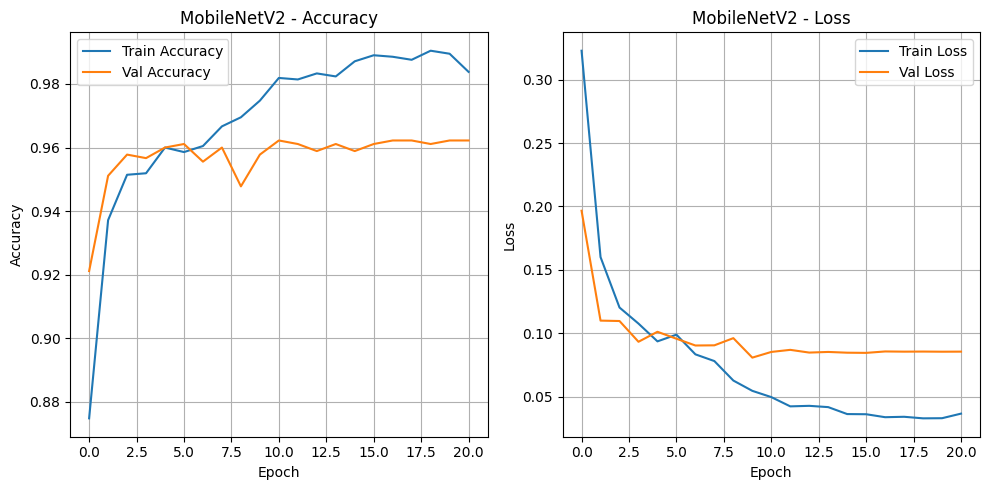

In [18]:
#Plots for MobileNetV2 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Cnfusion matrix
#Prediction on validation data
val_pred_mobilenetv2 = model_mobilenetv2.predict(val_data_mobilenet)
y_pred_mobilenetv2 = np.argmax(val_pred_mobilenetv2, axis=1)

y_true_mobilenetv2 = val_data_mobilenet.classes

class_names = list(val_data.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


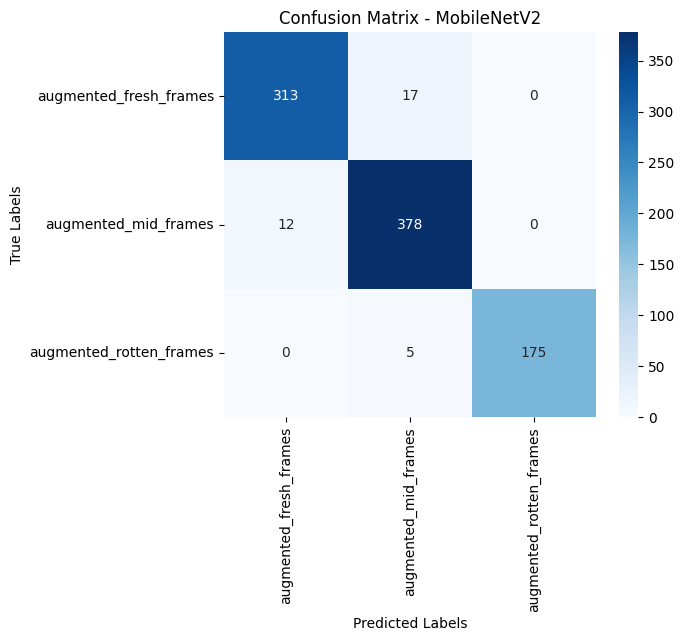

In [21]:
#confusion matrix
cm_mobilenetv2 = confusion_matrix(y_true_mobilenetv2, y_pred_mobilenetv2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_mobilenetv2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

## NASNetMobile

In [22]:
from tensorflow.keras.applications.nasnet  import preprocess_input

datagen_nasnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Training data
train_data_nasnet = datagen_nasnet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation data
val_data_nasnet = datagen_nasnet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [23]:
from tensorflow.keras.applications import NASNetMobile

#Loading NASNetMobile
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_nasnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
#Compilation
model_nasnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Summary
model_nasnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       270,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,079 (17.32 MB)

 Trainable params: 271,363 (1.04 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_nasnet = ModelCheckpoint(
    'nasnet_cpu.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_nasnet = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_nasnet = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_nasnet = time.time()

history_nasnet = model_nasnet.fit(
    train_data_nasnet,
    epochs=50,
    validation_data=val_data_nasnet,
    callbacks=[checkpoint_nasnet, reduce_lr_nasnet, early_stopping_nasnet]
)

end_nasnet = time.time()
runtime_nasnet = end_nasnet - start_nasnet

print(f"Training Time for NASNetMobile model: {runtime_nasnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7570 - loss: 0.5797
Epoch 1: val_accuracy improved from -inf to 0.91444, saving model to nasnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.7583 - loss: 0.5770 - val_accuracy: 0.9144 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8864 - loss: 0.2840
Epoch 2: val_accuracy improved from 0.91444 to 0.92444, saving model to nasnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.8866 - loss: 0.2834 - val_accuracy: 0.9244 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9337 - loss: 0.1701
Epoch 3: val_accuracy did not improve from 0.92444
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9336 - loss: 0.1704 - val_accuracy: 0.8978 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9132 - loss: 0.2063
Epoch 4: val_accuracy improved from 0.92444 to 0.93000, saving model to nasnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9134 - loss: 0.2058 - val_accuracy: 0.9300 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9360 - loss: 0.1531
Epoch 5: val_accuracy improved from 0.93000 to 0.94333, saving model to nasnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9361 - loss: 0.1530 - val_accuracy: 0.9433 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9588 - loss: 0.1284
Epoch 6: val_accuracy did not improve from 0.94333
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.9587 - loss: 0.1286 - val_accuracy: 0.9300 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9455 - loss: 0.1247
Epoch 7: val_accuracy improved from 0.94333 to 0.94667, saving model to nasnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9455 - loss: 0.1247 - val_accuracy: 0.9467 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9605 - loss: 0.0986
Epoch 8: val_accuracy did not improve from 0.94667
66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9604 - loss: 0.0988 - val_accuracy: 0.9456 - val_loss: 0.1339 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9618 - loss: 0.0960
Epoch 9: val_accuracy did not improve from 0.94667
66/66 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9617 - loss: 0.0960 - val_accuracy: 0.9467 - val_loss: 0.1298 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9597 - loss: 0.0878
Epoch 10: val_accuracy did not improve from 0.94667

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9596 - loss: 0.0880 - val_accuracy: 0.9456 

66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.9624 - loss: 0.0991 - val_accuracy: 0.9511 - val_loss: 0.1217 - learning_rate: 2.0000e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9749 - loss: 0.0640
Epoch 12: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9748 - loss: 0.0642 - val_accuracy: 0.9500 - val_loss: 0.1226 - learning_rate: 2.0000e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9658 - loss: 0.0787
Epoch 13: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9658 - loss: 0.0786 - val_accuracy: 0.9467 - val_loss: 0.1157 - learning_rate: 2.0000e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9743 - loss: 0.0657
Epoch 14: val_accuracy did not improve from 0.95111

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9743 - loss: 0.0657 - val_a

In [26]:
# model_nasnet = load_model("nasnet_cpu.h5")

In [27]:
loss_nasnet, accuracy_nasnet = model_nasnet.evaluate(val_data_nasnet)
print(f"Validation Accuracy: {accuracy_nasnet:.4f}, Validation Loss: {loss_nasnet:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9455 - loss: 0.1260
Validation Accuracy: 0.9511, Validation Loss: 0.1217


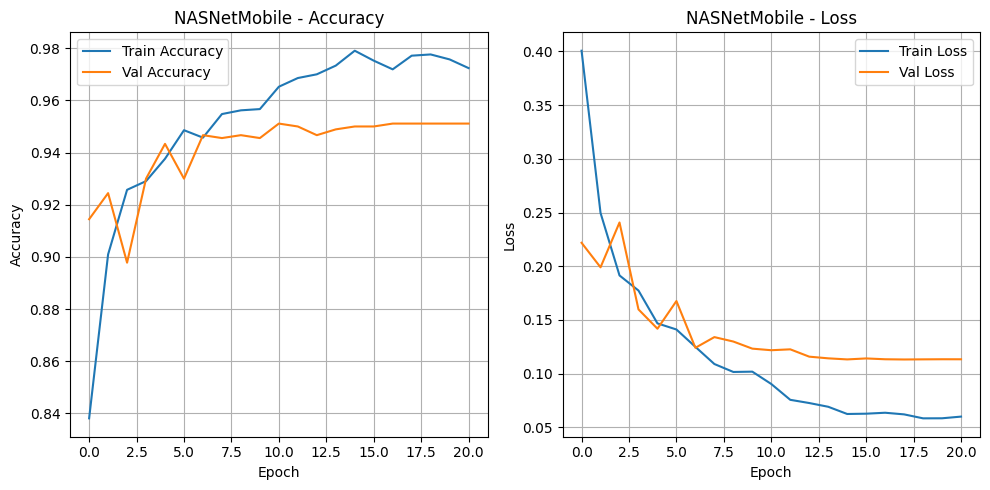

In [28]:
#Plots for NASNetMobile Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_nasnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_nasnet.history['val_accuracy'], label='Val Accuracy')
plt.title('NASNetMobile - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_nasnet.history['loss'], label='Train Loss')
plt.plot(history_nasnet.history['val_loss'], label='Val Loss')
plt.title('NASNetMobile - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
#Cnfusion matrix
#Prediction on validation data
val_pred_nasnet = model_nasnet.predict(val_data_nasnet)
y_pred_nasnet = np.argmax(val_pred_nasnet, axis=1)

y_true_nasnet = val_data_nasnet.classes

class_names = list(val_data_nasnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step


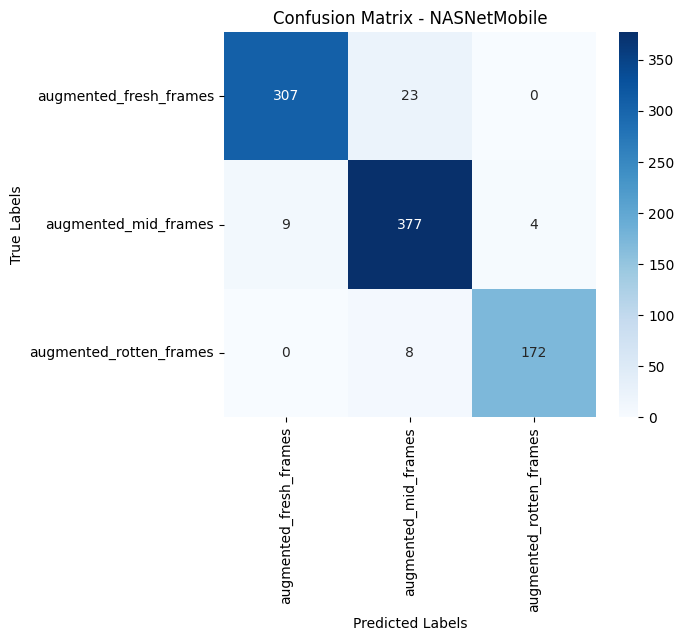

In [30]:
cm_nasnet = confusion_matrix(y_true_nasnet, y_pred_nasnet)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nasnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - NASNetMobile')
plt.show()

## ResNet50

In [31]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

batch_size = 32
img_size = (224, 224)

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [32]:
from tensorflow.keras.applications import ResNet50

#Loading Resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#model building
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [33]:
#Compilation
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_resnet = ModelCheckpoint(
    'resnet_cpu.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_resnet = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_resnet = time.time()

history_resnet = model_resnet.fit(
    train_data_resnet,
    epochs=50,
    validation_data=val_data_resnet,
    callbacks=[checkpoint_resnet, reduce_lr_resnet, early_stopping_resnet]
)

end_resnet = time.time()
runtime_resnet = end_resnet - start_resnet

print(f"Training Time for ResNet50 model: {runtime_resnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7853 - loss: 0.6285
Epoch 1: val_accuracy improved from -inf to 0.92222, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 530s 8s/step - accuracy: 0.7865 - loss: 0.6249 - val_accuracy: 0.9222 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9270 - loss: 0.1693
Epoch 2: val_accuracy improved from 0.92222 to 0.93778, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 511s 8s/step - accuracy: 0.9271 - loss: 0.1690 - val_accuracy: 0.9378 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9449 - loss: 0.1429
Epoch 3: val_accuracy improved from 0.93778 to 0.95444, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 559s 8s/step - accuracy: 0.9449 - loss: 0.1429 - val_accuracy: 0.9544 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9483 - loss: 0.1256
Epoch 4: val_accuracy did not improve from 0.95444
66/66 ━━━━━━━━━━━━━━━━━━━━ 510s 8s/step - accuracy: 0.9484 - loss: 0.1255 - val_accuracy: 0.9544 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9612 - loss: 0.1084
Epoch 5: val_accuracy did not improve from 0.95444
66/66 ━━━━━━━━━━━━━━━━━━━━ 526s 8s/step - accuracy: 0.9611 - loss: 0.1084 - val_accuracy: 0.9500 - val_loss: 0.1191 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9514 - loss: 0.1040
Epoch 6: val_accuracy improved from 0.95444 to 0.95667, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 515s 8s/step - accuracy: 0.9514 - loss: 0.1039 - val_accuracy: 0.9567 - val_loss: 0.0878 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9558 - loss: 0.0827
Epoch 7: val_accuracy improved from 0.95667 to 0.96000, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 512s 8s/step - accuracy: 0.9558 - loss: 0.0827 - val_accuracy: 0.9600 - val_loss: 0.1157 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9607 - loss: 0.0910
Epoch 8: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 509s 8s/step - accuracy: 0.9605 - loss: 0.0912 - val_accuracy: 0.9567 - val_loss: 0.1159 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9684 - loss: 0.0735
Epoch 9: val_accuracy improved from 0.96000 to 0.96333, saving model to resnet_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 510s 8s/step - accuracy: 0.9684 - loss: 0.0735 - val_accuracy: 0.9633 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9718 - loss: 0.0657
Epoch 10: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 499s 8s/step - accuracy: 0.9717 - loss: 0.0657 - val_accuracy: 0.9622 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9616 - loss: 0.0847
Epoch 11: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - accuracy: 0.9615 - loss: 0.0848 - val_accuracy: 0.9389 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9638 - loss: 0.0823
Epoch 12: val_accuracy did not improve from 0.96333

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 504s 8s/step - accuracy: 0.9637 - loss: 0.0824 - val_accuracy: 0.9

66/66 ━━━━━━━━━━━━━━━━━━━━ 597s 8s/step - accuracy: 0.9715 - loss: 0.0566 - val_accuracy: 0.9644 - val_loss: 0.0755 - learning_rate: 2.0000e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9823 - loss: 0.0413
Epoch 14: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 584s 9s/step - accuracy: 0.9823 - loss: 0.0413 - val_accuracy: 0.9556 - val_loss: 0.0749 - learning_rate: 2.0000e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9845 - loss: 0.0389
Epoch 15: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 550s 8s/step - accuracy: 0.9845 - loss: 0.0389 - val_accuracy: 0.9633 - val_loss: 0.0768 - learning_rate: 2.0000e-04
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9816 - loss: 0.0419
Epoch 16: val_accuracy did not improve from 0.96444

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 534s 8s/step - accuracy: 0.9816 - loss: 0.0419 - val_a

In [ ]:
# model_resnet = load_model("resnet_cpu.h5")

In [35]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(val_data_resnet)
print(f"Validation Accuracy: {accuracy_resnet:.4f}, Validation Loss: {loss_resnet:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9513 - loss: 0.0840
Validation Accuracy: 0.9644, Validation Loss: 0.0755


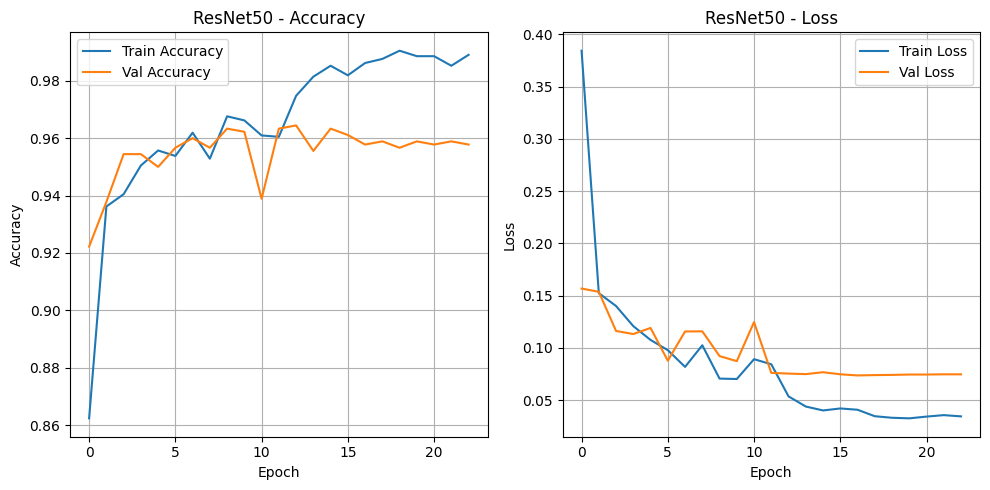

In [36]:
#Plots for ResNet50 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
#Prediction on validation data
val_pred_resnet = model_resnet.predict(val_data_resnet)
y_pred_resnet = np.argmax(val_pred_resnet, axis=1)

y_true_resnet = val_data_resnet.classes

class_names = list(val_data_resnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step


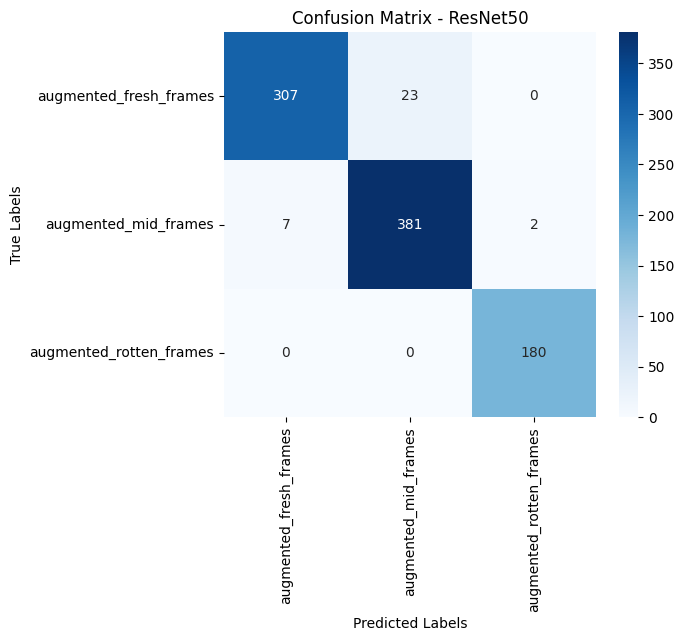

In [38]:
#Confusion matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet50")
plt.show()